## Рекомендации на основе содержания

Построить рекомендации (регрессия, предсказываем оценку) на фичах курсов:
- TF-IDF 
- Оценить RMSE на тестовой выборке

In [242]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [243]:
courses_df = pd.read_csv('coursera.csv')

## Анализ датасета

In [244]:
courses_df.tail(2)

,Unnamed: 0,position,course_id,title,breadcrumbs,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
1772,1772,1773,zhuangzi,"莊子─姿勢、意識與感情 (Zhuangzi─Posture, Awareness, and ...","['Arts and Humanities', 'Philosophy']",他這麼活過他的一生，留下一本書，《莊子》。這本書影響了陶淵明的一生，影響了李太白的一生，...,['蔡璧名'],Chinese (Traditional),"['9,832 already enrolled!', '5,474 recent views']","['100% online', 'Flexible deadlines', 'Beginne...",4.8,129.0,36.0,[],"['〈逍遙遊〉〈一〉', '〈逍遙遊〉〈二〉', '〈齊物論〉〈一〉', '〈齊物論〉〈二〉']","['kunqu-opera', 'classics-chinese-humanities']",https://www.coursera.org/learn/zhuangzi
1773,1773,1774,zika,In the footsteps of Zika… approaching the unknown,"['Health', 'Public Health']",Welcome !\n\nWelcome to this on-demand MOOC “I...,"['Antoine Flahault', 'Aline Philibert (In Part...",English,"['3,968 already enrolled!']","['100% online', 'Flexible deadlines', 'Interme...",NaN,95.0,NaN,[],"['Introducing Zika virus, its vectors and its ...","['global-health-overview', 'screening']",https://www.coursera.org/learn/zika


In [245]:
#избавимся от лишних столбцов
courses_df=courses_df.drop(['position'], axis=1)

In [246]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 16 columns):
Unnamed: 0         1774 non-null int64
course_id          1774 non-null object
title              1774 non-null object
breadcrumbs        1774 non-null object
about              1774 non-null object
instructors        1774 non-null object
language           1774 non-null object
metrics            1774 non-null object
product_glance     1774 non-null object
average_score      1641 non-null float64
ratings_count      1504 non-null float64
reviews_count      1606 non-null float64
skills             1774 non-null object
syllabus           1774 non-null object
recommendations    1774 non-null object
url                1774 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 221.8+ KB


In [247]:
#object в int64
# to change use .astype() 
courses_df['course_id'] = courses_df.course_id.astype(str)

In [250]:
#заменим пропущенные значения на нули
courses_df['average_score'] = courses_df.average_score.fillna(value = 0)
courses_df['reviews_count'] = courses_df.reviews_count.fillna(value = 0)
courses_df['ratings_count'] = courses_df.reviews_count.fillna(value = 0)

In [248]:
#количество уникальных курсов - проверим на повторы
courses_df.course_id.nunique()

1774

In [251]:
#переименуем столбец 'breadcrumbs'
courses_df.rename(columns={'breadcrumbs': 'topics'}, 
                 inplace=True)
courses_df.head(2)

,Unnamed: 0,course_id,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
0,0,2-speed-it,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33.0,33.0,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it
1,1,20cnwm,20世纪西方音乐 Western Music in the 20th Century,"['Arts and Humanities', 'Music and Art']",课程所涉不仅涵盖古典音乐如新古典主义、表现主义、民族主义等流派，也对爵士乐、摇滚乐与流行音乐...,['毕明辉 Bryan Minghui BI'],Chinese (Simplified),"['1,795 already enrolled!']","['100% online', 'Flexible deadlines', 'Beginne...",4.3,6.0,6.0,[],"['音乐的史纲与音乐的风格', '音乐的空间与音乐的时间', '20世纪西方音乐的多元新秩序...","['kunqu-opera', 'understanding-china-history-p...",https://www.coursera.org/learn/20cnwm


In [253]:
courses_df.ratings_count = courses_df.ratings_count.astype(int)
courses_df.reviews_count = courses_df.reviews_count.astype(int)

In [254]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 16 columns):
Unnamed: 0         1774 non-null int64
course_id          1774 non-null object
title              1774 non-null object
topics             1774 non-null object
about              1774 non-null object
instructors        1774 non-null object
language           1774 non-null object
metrics            1774 non-null object
product_glance     1774 non-null object
average_score      1774 non-null float64
ratings_count      1774 non-null int64
reviews_count      1774 non-null int64
skills             1774 non-null object
syllabus           1774 non-null object
recommendations    1774 non-null object
url                1774 non-null object
dtypes: float64(1), int64(3), object(12)
memory usage: 221.8+ KB


In [255]:
courses_df.describe()

,Unnamed: 0,average_score,ratings_count,reviews_count
count,1774.000000,1774.000000,1774.000000,1774.000000
mean,886.500000,4.275874,113.305524,113.305524
std,512.254006,1.234137,160.509912,160.509912
min,0.000000,0.000000,0.000000,0.000000
25%,443.250000,4.500000,19.000000,19.000000
50%,886.500000,4.600000,53.000000,53.000000
75%,1329.750000,4.800000,135.000000,135.000000
max,1773.000000,5.000000,993.000000,993.000000


In [256]:
# Распредение признаков
courses_df['language'].value_counts()

English                   1299
Spanish                    193
Chinese (Simplified)        83
Russian                     72
French                      53
Portuguese (Brazilian)      30
Chinese (Traditional)       27
Turkish                      4
None                         4
Arabic                       3
Hebrew                       3
Ukrainian                    2
Swedish                      1
Name: language, dtype: int64

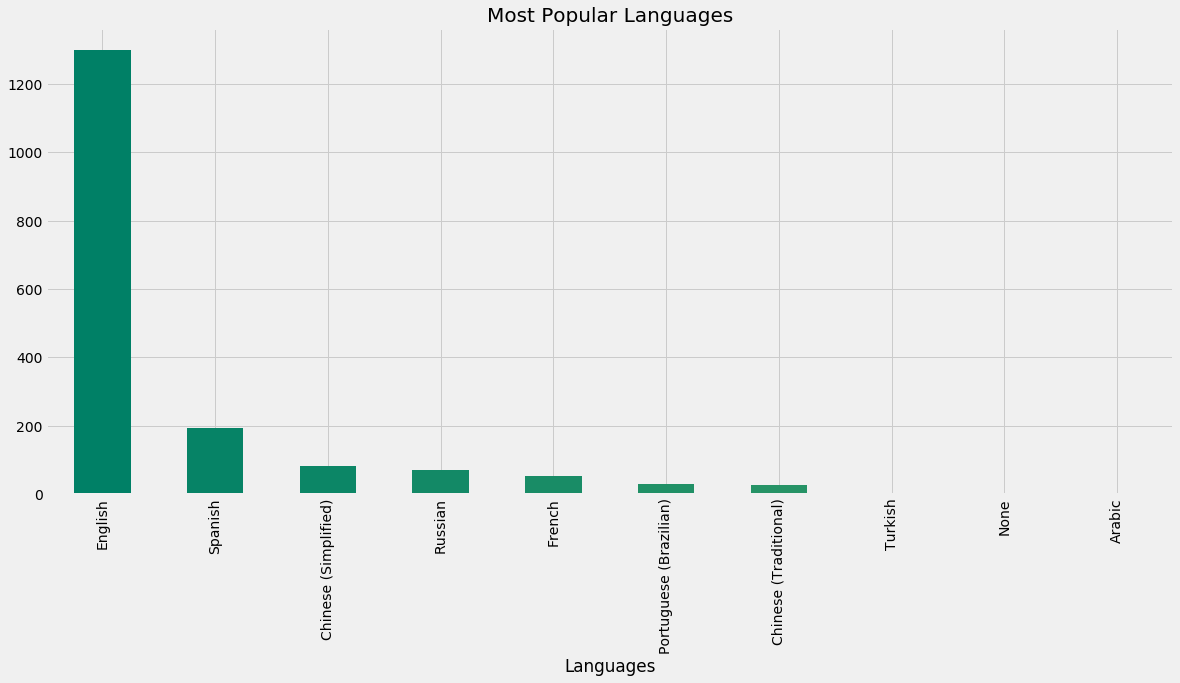

In [257]:
#визуализируем самые популярные курсы

plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.summer(np.linspace(0, 2, 80))
courses_df['language'].value_counts().head(10).plot.bar(color = color)
plt.title('Most Popular Languages', fontsize = 20, fontweight = 30)
plt.xlabel('Languages')
plt.show()

In [258]:
#Для удобства работы с языковыми библиотеками выделим из общего датасета курсы на английском и на русском языках

In [259]:
courses_eng = courses_df[courses_df['language'] == 'English']
courses_eng

,Unnamed: 0,course_id,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
0,0,2-speed-it,Two Speed IT: How Companies Can Surf the Digit...,"['Business', 'Business Essentials']","Transform or disappear, the Darwinism of IT: I...","['Antoine Gourévitch', 'Vanessa Lyon', 'Eric B...",English,"['16,728 already enrolled!', '5,149 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.4,33,33,[],"['Introduction', 'IT and the CIO in the Digita...","['fundamentals-of-management', 'entrepreneuria...",https://www.coursera.org/learn/2-speed-it
5,5,3d-printing-applications,3D Printing Applications,"['Business', 'Entrepreneurship']",This course will help you understand how 3D pr...,['Vishal Sachdev'],English,"['11,308 already enrolled!', '8,209 recent vie...","['100% online', 'Flexible deadlines', 'Beginne...",4.5,92,92,[],"['Course Orientation', 'Module 1: 3D Printing ...","['mechanics2', 'beam-bending']",https://www.coursera.org/learn/3d-printing-app...
6,6,3d-printing-revolution,The 3D Printing Revolution,"['Business', 'Entrepreneurship']",This course will demonstrate how 3D printers w...,['Aric Rindfleisch'],English,"['20,657 already enrolled!', '10,843 recent vi...","['100% online', 'Flexible deadlines', 'Beginne...",4.7,221,221,"['Materials', 'Product Development', 'New Prod...","['Course Orientation', 'Module 1: What Is 3D P...","['mechanics2', 'beam-bending']",https://www.coursera.org/learn/3d-printing-rev...
7,7,3d-printing-software,3D Printing Software,"['Business', 'Entrepreneurship']",This course will demonstrate how to use 3D pri...,['Jeffrey Smith'],English,"['13,266 already enrolled!', '20,828 recent vi...","['100% online', 'Flexible deadlines', 'Beginne...",4.5,59,59,[],"['Course Orientation', 'Module 1: Design Sketc...","['mechanics2', 'beam-bending']",https://www.coursera.org/learn/3d-printing-sof...
9,9,abdomen-anatomy,Anatomy of the Abdomen and Pelvis; a journey f...,"['Health', 'Basic Science']",In this anatomy course you will explore the or...,"['Marco De Ruiter, PhD', 'Paul Gobée, MD', 'Be...",English,"['41,565 already enrolled!', '12,090 recent vi...","['100% online', 'Flexible deadlines', 'Approx....",4.7,92,92,[],"['Introduction', 'Mapping the abdomen and pelv...","['cancer-metastasis', 'cancer']",https://www.coursera.org/learn/abdomen-anatomy
10,10,ableton-live,Introduction to Ableton Live,"['Arts and Humanities', 'Music and Art']","In the past, Digital Audio Workstations (DAWs)...",['Erin Barra'],English,"['53,031 already enrolled!', '20,560 recent vi...","['100% online', 'Flexible deadlines', 'Approx....",4.8,246,246,"['Audio Recording', 'File Management', 'Music ...","['Welcome to Introduction to Ableton Live', 'G...","['musicianship-harmony', 'musicianship-chords']",https://www.coursera.org/learn/ableton-live
11,11,aboriginal-education,Aboriginal Worldviews and Education,"['Social Sciences', 'Education']",Intended for both Aboriginal and non-Aborigina...,['Jean-Paul Restoule'],English,"['4,590 already enrolled!', '5,171 recent views']","['100% online', 'Flexible deadlines', 'Approx....",4.7,34,34,[],"['Welcome and Orientation to the Course', 'Abo...",['block-programming-k12-educators-nested-if-st...,https://www.coursera.org/learn/aboriginal-educ...
12,12,academic-discussion-english,Academic Discussions in English,"['Language Learning', 'Learning English']",This is the third course in the Learn English:...,"['Tamy Chapman', 'Meg Parker', 'Helen Nam', 'B...",English,"['11,916 already enrolled!', '8,010 recent vie...","['Course 3 of 4 in the', '100% online', 'Flexi...",0.0,0,0,[],"['Introduction to Discussions', 'Elaboration',...","['conjunctions-connectives-adverb-clauses', 'n...",https://www.coursera.org/learn/academic-discus...
13,13,academic-literacy,Academic Literacy,"['Language Learning', 'Learning English']",This is the first course of the English for Re...,['Elena Bazanova'],English,"['9,006 already enro

In [260]:
courses_ru = courses_df[courses_df['language'] == 'Russian']
courses_ru

,Unnamed: 0,course_id,title,topics,about,instructors,language,metrics,product_glance,average_score,ratings_count,reviews_count,skills,syllabus,recommendations,url
4,4,3d-printing,3D-печать для всех и каждого,"['Computer Science', 'Design and Product']",Наверняка многие из вас слышали о трёхмерной п...,['Николай Георгиевич Булахов (Nikolay G. Bulak...,Russian,"['6,133 already enrolled!', '1,739 recent views']","['100% online', 'Flexible deadlines', 'Approx....",4.7,15,15,[],['Добро пожаловать на курс «3D-печать для всех...,"['system-validation-behavior', 'system-validat...",https://www.coursera.org/learn/3d-printing
48,48,algebra-lineynaya,Линейная алгебра (Linear Algebra),"['Math and Logic', 'Math and Logic']","Это стандартный курс линейной алгебры, содержа...",['Irina Khovanskaya'],Russian,"['17,042 already enrolled!', '24,307 recent vi...","['100% online', 'Flexible deadlines', 'Beginne...",4.5,34,34,[],"['Понятие линейного пространства ', 'Линейные ...","['galois', 'enumerative-combinatorics']",https://www.coursera.org/learn/algebra-lineynaya
120,120,astrofizika,Астрофизика: от звезд до границ Вселенной,"['Physical Science and Engineering', 'Physics ...",Этот курс посвящен ключевым проблемам современ...,['Варшалович Дмитрий Александрович'],Russian,"['4,505 already enrolled!', '2,738 recent views']","['100% online', 'Flexible deadlines', 'Approx....",4.8,6,6,[],"['Звезды: от рождения до смерти', 'Основы теор...","['how-things-work', 'big-bang']",https://www.coursera.org/learn/astrofizika
174,174,bioinformatika,Введение в биоинформатику (Introduction to Bio...,"['Health', 'Health Informatics']",Курс «Введение в биоинформатику» адресован тем...,"['Alla L Lapidus', 'Николай Вяххи', 'Павел До...",Russian,"['6,268 already enrolled!', '5,260 recent views']","['100% online', 'Flexible deadlines', 'Beginne...",0.0,0,0,[],"['Неделя 1 - Введение (Week 1 - Introducton)',...","['comparing-genomes', 'genome-sequencing']",https://www.coursera.org/learn/bioinformatika
176,176,biosensory,Биосенсоры,"['Health', 'Research']",Чем больше информации об окружающей среде полу...,['Анна Юшкова'],Russian,"['2,977 already enrolled!']","['100% online', 'Flexible deadlines', 'Beginne...",0.0,0,0,[],"['Молекулярные основы сенсорных систем', 'Меха...","['mastering-statics', 'disease-genes']",https://www.coursera.org/learn/biosensory
186,186,bulgakov-master-i-margarita,Читаем русскую классику вместе. М. Булгаков «...,"['Language Learning', 'Other Languages']",Курс «Читаем русскую классику вместе. М. Булга...,['Татьяна Борисовна Банкова (Tatiana B. Bankov...,Russian,"['7,849 already enrolled!', '2,168 recent views']","['100% online', 'Flexible deadlines', 'Approx....",4.5,11,11,[],['Добро пожаловать на курс «Читаем русскую кла...,"['economy-russia-transition', 'modern-art-ideas']",https://www.coursera.org/learn/bulgakov-master...
240,240,cennye-bumagi-pravovoe-regulirovanie,Ценные бумаги: правовое регулирование,"['Business', 'Finance']",Основное внимание в процессе освоения курса на...,['Селивановский Антон Сергеевич'],Russian,"['11,435 already enrolled!', '6,380 recent vie...","['100% online', 'Flexible deadlines', 'Approx....",4.8,23,23,[],"['Введение', 'Тема 1. Значение и участники фон...","['european-law-fundamentals', 'eu-law-doing-bu...",https://www.coursera.org/learn/cennye-bumagi-p...
378,378,data-analysis-applications,Прикладные задачи анализа данных,"['Data Science', 'Data Analysis']",Методы машинного обучения — будь то алгоритмы ...,"['Evgeniy Riabenko', 'Evgeny Sokolov', 'Victor...",Russian,"['10,322 already enrolled!', '24,602 recent vi...","['Course 5 of 6 in the', '100% online', 'Flexi...",4.4,84,84,"['Data Science', 'Time Series', 'Sentiment Ana...","['Бизнес-задачи', 'Анализ медиа', 'Анализ текс...","['big-data-essentials', 'intro-to-deep-learning']",https://www.coursera.org/learn/data-analysis-a...
380,380,data-analysis-project,Анализ данных: финальный проект,"['Data Science', 'Data Analysis']",Финальный проект даст вам возможность примен

In [261]:
print(len(courses_df.loc[courses_df['language'] == 'Russian']))

72


In [265]:
#проверим соответствует ли размар выделенного датасета с курсами на русском языке количеству русскоязычных курсов в исходном датасете
print(len(courses_ru['language']))

72


### TFIDF для рекоммендаций
TF (term frequency — частота слова) — отношение числа вхождений некоторого слова к общему числу слов документа. Таким образом, оценивается важность слова $ t_{i} $ в пределах отдельного документа.

$${\displaystyle \mathrm {tf} (t,d)={\frac {n_{t}}{\sum _{k}n_{k}}}},$$
где ${\displaystyle n_{t}}$ есть число вхождений слова ${\displaystyle t}$ в документ, а в знаменателе — общее число слов в данном документе.

IDF (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции. Основоположником данной концепции является Карен Спарк Джонс. Учёт IDF уменьшает вес широкоупотребительных слов. Для каждого уникального слова в пределах конкретной коллекции документов существует только одно значение IDF.

$${\mathrm {idf} (t,D)=\log {\frac {|D|}{|\{\,d_{i}\in D\mid t\in d_{i}\,\}|}}}$$
, где

|D| — число документов в коллекции; ${\displaystyle |\{\,d_{i}\in D\mid t\in d_{i}\,\}|}$ — число документов из коллекции D, в которых встречается t (когда ${\displaystyle n_{t}\neq 0}$).